Импорт необходимых библиотек

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import dask.dataframe as dd

Файл открывается dack(это быстрее) и переводится в пандас с экономией памяти за счет указания типов.

In [4]:
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

data = dd.read_csv(r'C:\data sets\train.csv', dtype=dtypes).compute()

In [6]:
train_df = data.copy()

## Знакомство с данными

*1. Рассмотрим основной датасет.*

In [7]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,<NA>
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False


In [50]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101230332 entries, 0 to 1080610
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 boolean
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(2), float32(1), int16(2), int32(1), int64(2), int8(2)
memory usage: 4.0 GB


In [51]:
train_df.isnull().sum()

row_id                                  0
timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64

Нули видим в двух признаках, работа с ними будет выполнена позднее.

Удалим дубликаты.

In [52]:
train_df = train_df.drop_duplicates()


*2.Рассмотрим еще два датасета (лекции и вопросы)*

In [8]:
qw_df = pd.read_csv(r"C:\data sets\questions.csv")
lec_df =pd.read_csv(r"C:\data sets\lectures.csv")

In [12]:
qw_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [14]:
qw_df.isnull().sum()

question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

Один вопрос без тега.

In [15]:
lec_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [16]:
lec_df.isnull().sum()

lecture_id    0
tag           0
part          0
type_of       0
dtype: int64

## Анализ взаимосвязей и заисимостей в данных.

## 1.Answered_correctly, User_ID

Сколько уникальных пользователей содержится в данных?

In [53]:
print(f'У нас имеется {train_df.user_id.nunique()} уникальных пользователей в наших данных')

У нас имеется 393656 уникальных пользователей в наших данных


Каково максимальное количество вопросов на которое корректно ответил пользователь?

In [54]:
user_percent = train_df[train_df.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'Наибольшее число вопросов, на которое корректно ответил пользователь {user_percent.Answers.max()}')

Наибольшее число вопросов, на которое корректно ответил пользователь 17609


Рассмотрим далее корректные ответы на вопросы.

In [55]:
train_df['answered_correctly'].value_counts(normalize = True)

answered_correctly
 1    0.644517
 0    0.336131
-1    0.019352
Name: proportion, dtype: float64

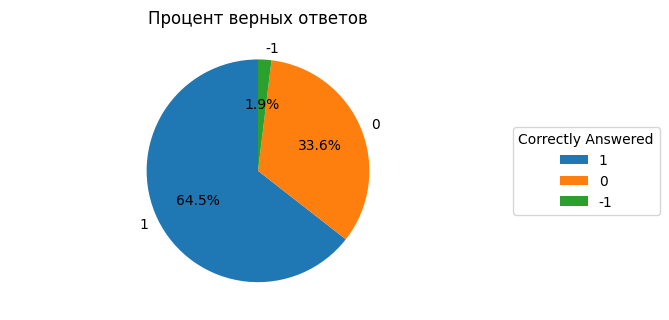

In [56]:
correct_counts = train_df['answered_correctly'].value_counts(normalize=True)

# Настройка лейблов
labels = list(correct_counts.index)
sizes = list(correct_counts.values)

# Создание фигуры
fig, ax = plt.subplots()
ax.axis('equal')  
plt.subplots_adjust(bottom=0.3)

# Определение фигуры как пирогакруговой диаграммы
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Добавить заглавие
plt.title("Процент верных ответов")
ax.legend(wedges, labels, title="Correctly Answered", loc="center left", bbox_to_anchor=(1, 0, 1, 1))

legend = True
# Легенду отобразить
plt.show()

*Как мы видим, большая часть ответов дана верно, значение составляет 64%.*

### **2.Далее рассмотрим влияние обьяснения на корректность ответов. Признак prior_question_had_explanation**

In [13]:
explanation_correct = train_df.groupby('prior_question_had_explanation')['answered_correctly'].mean()
print(explanation_correct)

prior_question_had_explanation
False    0.237025
True     0.673189
Name: answered_correctly, dtype: float64


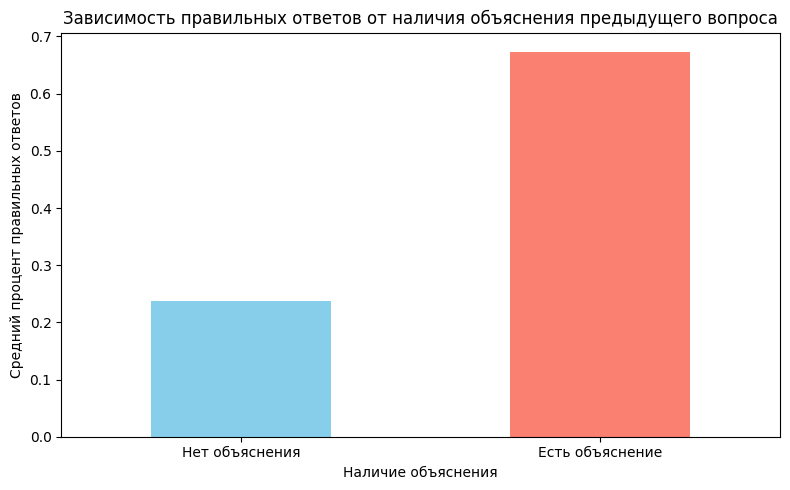

In [14]:
plt.figure(figsize=(8, 5))
explanation_correct.plot(kind='bar', color=['skyblue', 'salmon'])

# Настройка заголовка и меток осей
plt.title('Зависимость правильных ответов от наличия объяснения предыдущего вопроса')
plt.xlabel('Наличие объяснения')
plt.ylabel('Средний процент правильных ответов')

# Настройка меток по оси x
plt.xticks(ticks=[0, 1], labels=['Нет объяснения', 'Есть объяснение'], rotation=0)

# Показать график
plt.tight_layout()
plt.show()

**Поможет ли это, если в "предварительном вопросе" будет указано объяснение? Да, как видим, процент правильных ответов примерно на 17% выше, чем при наличии объяснения.**

## **3.Рассмотрим успеваемость по времени ответа. Признак prior_question_elapsed_time**

In [59]:
etime_correct = train_df.groupby('prior_question_elapsed_time')['answered_correctly'].mean()
print(etime_correct)


prior_question_elapsed_time
0.0         0.618971
200.0       0.715847
250.0       0.553957
333.0       0.698964
400.0       0.663158
              ...   
299600.0    0.333333
299666.0    1.000000
299750.0    0.538462
299800.0    0.615385
300000.0    0.619951
Name: answered_correctly, Length: 3258, dtype: float64


C:\Users\kovalev\AppData\Local\Temp\ipykernel_4248\2778562054.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  etime_correct = train_df.groupby('elapsed_time_bins')['answered_correctly'].mean()


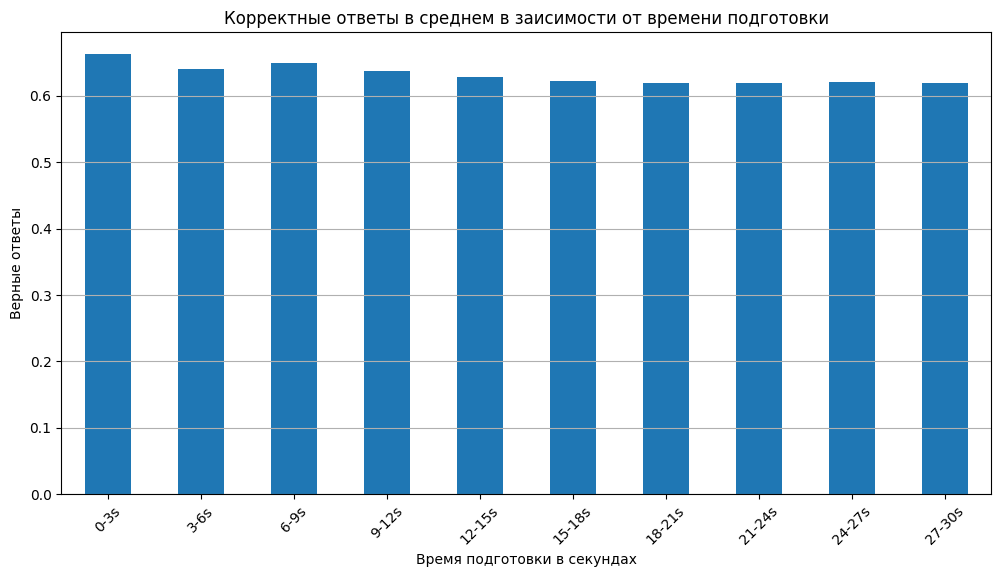

In [9]:
bins = [0, 30000, 60000, 90000, 120000, 150000, 180000, 210000, 240000, 270000, 300000]
labels = ['0-3s', '3-6s', '6-9s', '9-12s', '12-15s', '15-18s', '18-21s', '21-24s', '24-27s', '27-30s']

# Создание новой колонки с бинами
train_df['elapsed_time_bins'] = pd.cut(train_df['prior_question_elapsed_time'], bins=bins, labels=labels)

# Группировка по бинам и расчет среднего значения
etime_correct = train_df.groupby('elapsed_time_bins')['answered_correctly'].mean()

# Визуализация
plt.figure(figsize=(12, 6))
etime_correct.plot(kind='bar')
plt.title('Корректные ответы в среднем в заисимости от времени подготовки')
plt.xlabel('Время подготовки в секундах')
plt.ylabel('Верные ответы')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Большой разницы невидно, но самый высокий столбец относится к самому короткому промежутку времени**

## 4.Признак timestamp и поиск взаимосвязи между корректным ответом от пользователя и врeменем между вопросами и первым взаимодействием пользователя с системой.

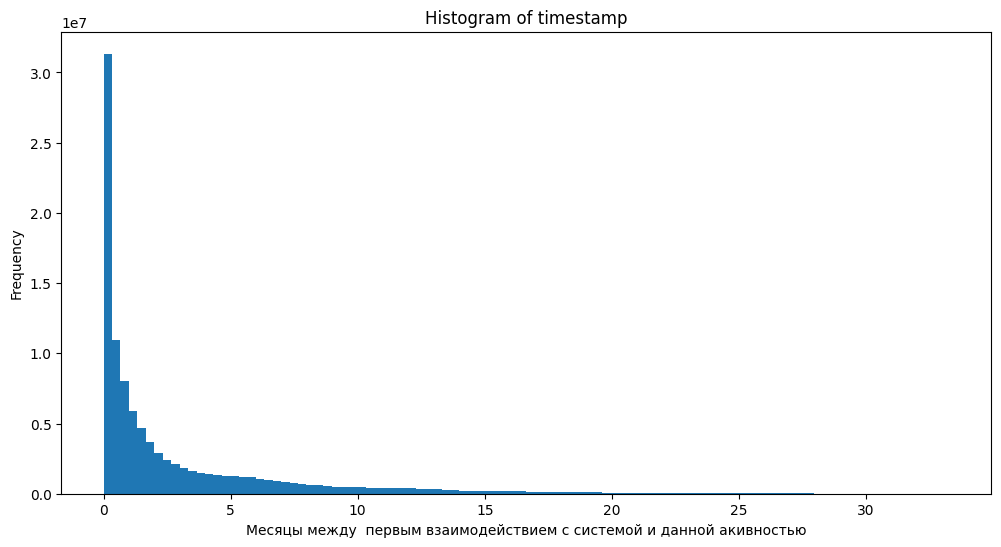

In [57]:
ts = train_df['timestamp']/(31536000000/12)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=100)
plt.title("Histogram of timestamp")
plt.xticks(rotation=0)
plt.xlabel("Месяцы между  первым взаимодействием с системой и данной акивностью")
plt.show()

**Как мы можем видеть, большинство взаимодействий происходит от пользователей, которые еще не были активны на платформе очень долго.**

## 6.Признак task_task_container_id. Попытка увязать данный признак с корректными ответами.

Идентификационный код пакета вопросов или лекций. Например, пользователь может просмотреть три вопроса подряд, прежде чем увидит пояснения к любому из них. Все эти трое будут иметь общий идентификатор task_container_id.

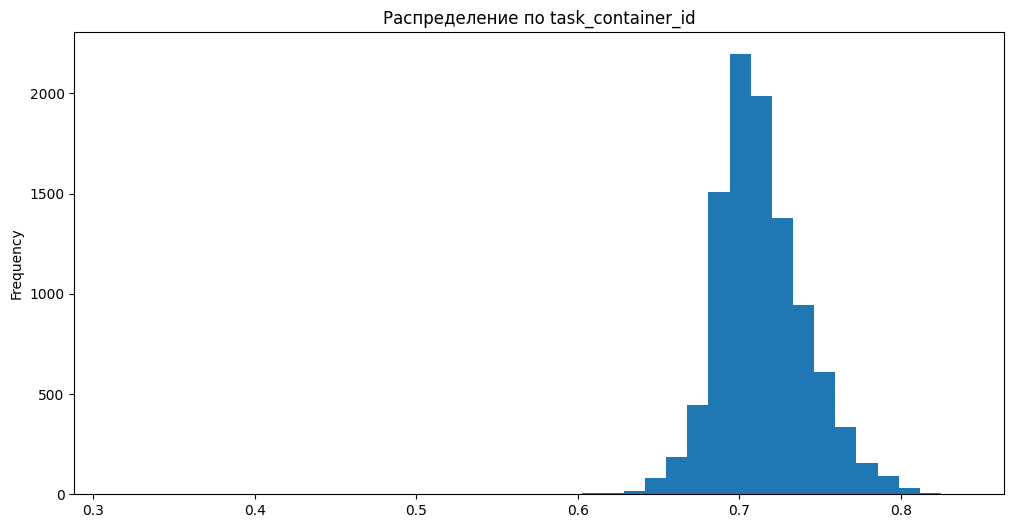

In [65]:
f_df =  train_df[train_df['answered_correctly']!=-1]
task_correct = f_df.groupby('task_container_id')['answered_correctly'].mean()


fig = plt.figure(figsize=(12,6))
task_correct.plot.hist(bins=40)
plt.title("Распределение по task_container_id")
plt.xticks(rotation=0)
plt.show()

**Очевидно, что какие-то задачи проще, какие-то сложнее. Данные распределены нормально. Сложность по частям раскроем позже после объединения с другими датасетами**

## Обьединение с датасетами questions и lectures с целью последующего анализа

In [60]:
lectures_merged = train_df[train_df['content_type_id'] == 1].merge(
    lec_df,
    left_on='content_id',
    right_on='lecture_id',
    how='left'
)

# Объединяем с questions_df, где content_type_id = 0
questions_merged = train_df[train_df['content_type_id'] == 0].merge(
    qw_df,
    left_on='content_id',
    right_on='question_id',
    how='left'
)

### Работа с тегами

Посмотрим сколько тегов в целом у нас есть.

In [61]:
qw_df['tags'] = qw_df['tags'].astype(str)

tags = [x.split() for x in qw_df[qw_df.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'У нас имеется {len(tags)} различных тегов')

У нас имеется 188 различных тегов


    tags  Total_questions  Total_right  Total_wrong  Percent_correct
153   68               18       104000        16378         0.863945
98   187               45       215776        36293         0.856020
36   130               37       207920        35788         0.853152
56   149               53       336639        60334         0.848015
123   40               27       184338        42176         0.813804
181   93               58       456157       107156         0.809775
156   70               46       235726        58176         0.802056
87   177               38       264031        65533         0.801152
135   51               71       257651        65922         0.796269
129   46               10        61711        56631         0.521463
107   26               22       265327       254876         0.510045
134   50               43       407525       397264         0.506375
142   58               11       187450       184005         0.504637
11   108               20       23

C:\Users\kovalev\AppData\Local\Temp\ipykernel_4248\184098018.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_tags, x='Percent_correct', y='tags', palette='coolwarm')


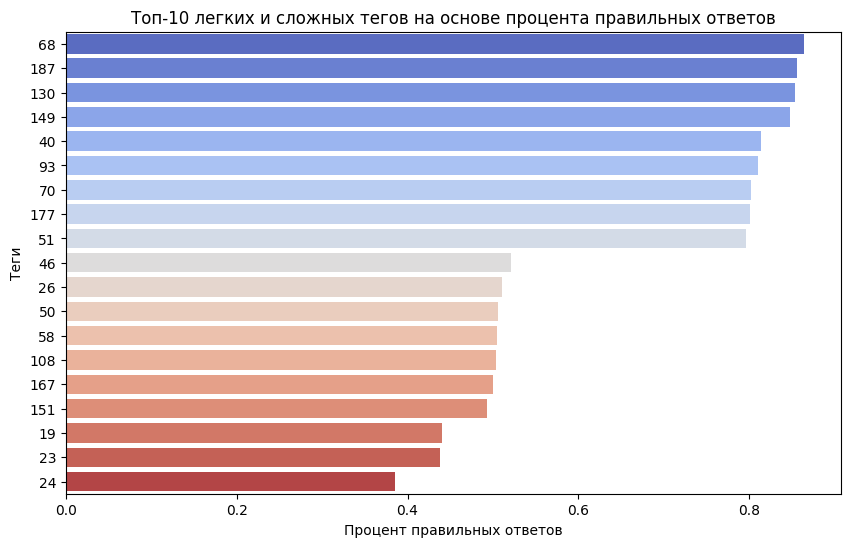

In [87]:
# Расширяем данные по тегам
tags_expanded = questions.explode('tags')

# Группировка и агрегация данных
tag_stats = tags_expanded.groupby('tags').agg(
    Total_questions=('question_id', 'count'),
    Total_right=('Right', 'sum'),
    Total_wrong=('Wrong', 'sum')
).reset_index()

# Удаление NaN значений после агрегации
tag_stats = tag_stats.dropna()

# Расчет Percent_correct
tag_stats['Percent_correct'] = tag_stats['Total_right'] / (tag_stats['Total_right'] + tag_stats['Total_wrong'])

# Удаление строк с NaN значениями в Percent_correct
tag_stats = tag_stats.dropna(subset=['Percent_correct'])

# Удаление тегов с нулевым количеством вопросов
tag_stats = tag_stats[tag_stats['Total_questions'] > 0]

tag_stats = tag_stats.dropna(subset=['tags'])

# Сортировка по Percent_correct для определения легких и сложных тегов
tag_stats.sort_values(by='Percent_correct', ascending=False, inplace=True)

# Выбор топ-10 самых легких и сложных тегов
top_easy_tags = tag_stats.head(10)
top_hard_tags = tag_stats.tail(10)

# Объединение топ-легких и топ-сложных тегов
top_tags = pd.concat([top_easy_tags, top_hard_tags])
top_tags = top_tags.dropna(subset=['tags'])
# Проверка на наличие NaN перед построением графика
top_tags = top_tags.dropna(subset=['tags'])
top_tags = top_tags.drop(index=188)

# Создание графика
plt.figure(figsize=(10, 6))

# Строим столбчатую диаграмму для объединенных тегов
sns.barplot(data=top_tags, x='Percent_correct', y='tags', palette='coolwarm')

# Добавляем заголовки и метки
plt.title('Топ-10 легких и сложных тегов на основе процента правильных ответов')
plt.xlabel('Процент правильных ответов')
plt.ylabel('Теги')

# Показываем график
plt.show()


**Итак, мы выяснили, что есть потенциально тяжелые и потенциально легкие теги. Рассмотрим количество вопросов для каждой части вопросов. Как видим, вопросы распределены неравномерно.**

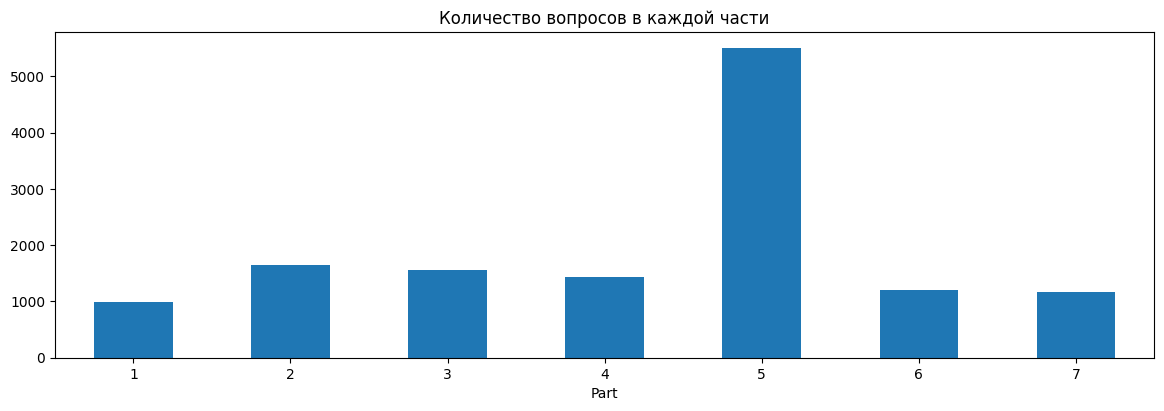

In [89]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1 = qw_df.groupby("part").count()['question_id'].plot.bar()
plt.title("Counts of part")
plt.xlabel("Part")
plt.xticks(rotation=0)

plt.title("Количество вопросов в каждой части")
plt.xlabel("Part")
plt.xticks(rotation=0)
plt.tight_layout(pad=2)
plt.show()

**Как мы видим, огромное количество вопросов в 5 части. Вопросы частям распределны неравномерно**

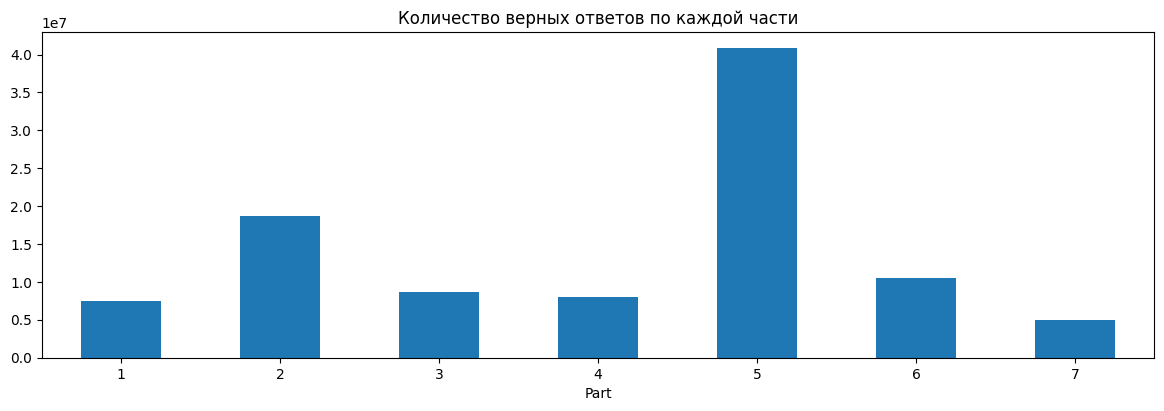

In [90]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1 = questions_merged.groupby("part").count()['answered_correctly'].plot.bar()
plt.title("Counts of part")
plt.xlabel("Part")
plt.xticks(rotation=0)

plt.title("Количество верных ответов по каждой части")
plt.xlabel("Part")
plt.xticks(rotation=0)
plt.tight_layout(pad=2)
plt.show()

** Наибольшее количество верных ответов было ожидаемо в 5 части, видимо, она самая легкая. Также очень много верных ответов сконцентрировано во 2 части, 

## Исследование лекций

In [42]:
print(f'Всего {lec_df.shape[0]} лекций.')

Всего 418 лекций.


**Как видим, из графика ниже, в основном лекции проводились по типу 'concept'. Совсем редко случаются лекции intention и starter**

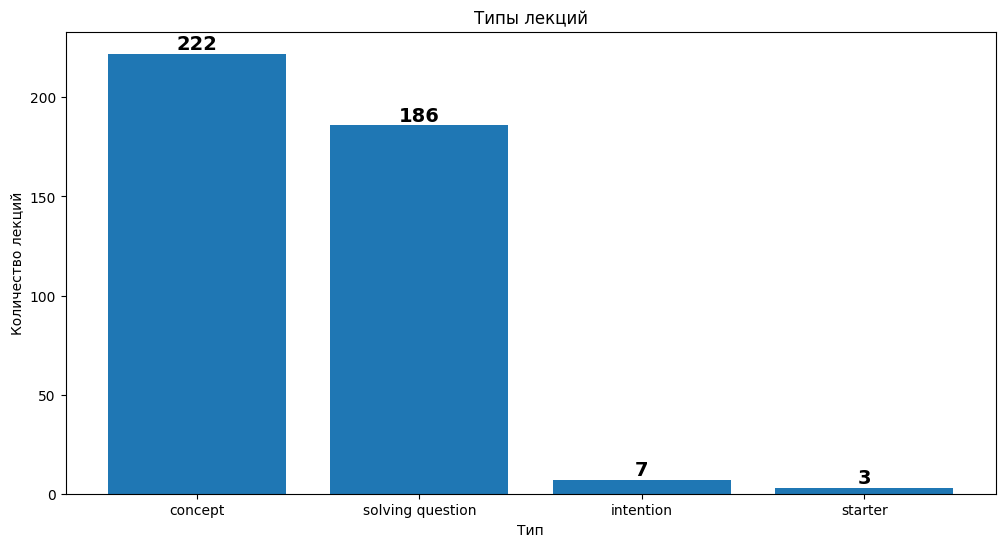

In [92]:
lect_type_of = lec_df.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("Типы лекций")
plt.xlabel("Тип")
plt.ylabel("Количество лекций")
plt.xticks(rotation=0)
plt.show()

Теперь посмотрим на то как соотносится тот факт, что студент слушал лекции и корректность ответа.

Watches_lecture
False    244050
True     149606
Name: count, dtype: int64


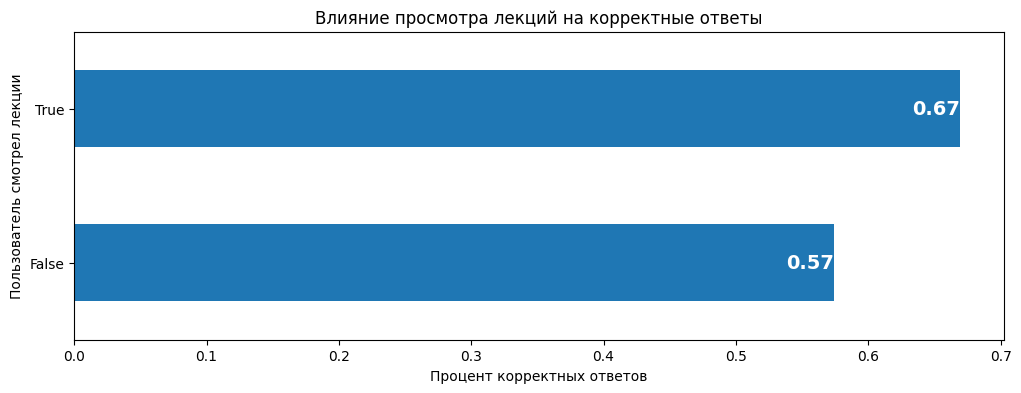

In [11]:
user_lect = train_df.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']})
print(user_lect.Watches_lecture.value_counts())

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)

watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("Влияние просмотра лекций на корректные ответы")
plt.xlabel("Процент корректных ответов")
plt.ylabel("Пользователь смотрел лекции")
plt.xticks(rotation=0)
plt.show()

**Как видим, посмотреть лекции (которых не так много) помогает! Некоторая помощь есть**

### Небольшое краткое резюме

**В ходе нашего исследования мы выяснили что у нас имеется 393656 уникальных пользователей в наших данных. Соответственно, мы выяснили, что ответы на вопросы производились неравномерно. Наибольшее число вопросов, на которое корректно ответил пользователь -17609. Активносями пользователей были лекции и вопросы. Большая часть ответов была корректной, это количество составило 64%. Мы увидели это на круговой диаграмме. Также мы рассмотрели взаимосвязь корректного ответа и обьяснения для предыдущего вопроса. И она действительно была, что иллюстрирует диаграмма вверху. Далее мы искали взаимосвязь корректных ответов и времени подгтовки на предыдущий вопрос, взаимосвязь не была существенной. Далее мы выяснили, что большая часть взаимодействий у нас от пользователей, которые относительно недавно на платформе(признак timestamp). Далее исследовались вопросы. Касательно вопросов мы увидели, что они состоят из 5 частей. Самой легкой является 5-я часть. Также в ней больше всего вопросов. Вторая по легкости - вторая часть. Провели работу с тегами, они были разными по сложности. Вывели десятку самых легких и самых тяжелых тегов. Так, например,самый сложный тег 24. А самый легкий - 68. У нас имеется  всего - 188 различных тегов Соответственно, взаимосвязь тегов и корректных ответов бесспорна. То же самое можно сказать о частях.  Далее мы исследовали лекции. Всего 418 лекций. В основном преобладают типы "concept" и 'solving question'. Мы проверили, есть ли взаимосвязь с просмотром лекций и корректностью ответов. Да. некоторая есть. Она составила 10%**